<a href="https://colab.research.google.com/github/ajaxr7781/eidreader/blob/main/AIML_Capstone_Corrected_FromCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIML Capstone — Vehicle Detection (YOLOv8) + Tesla Safety EDA
This Colab is corrected for **CSV labels** and fixes the earlier triple-quote issue.

**Parts**:
1) Convert `labels.csv` → YOLO txt, split, train YOLOv8
2) Clean & explore `Tesla-Deaths.csv`

**Setup**: Runtime → GPU, then run cells in order.

## 0) Environment Setup

In [ ]:
%pip -q install ultralytics==8.3.50
import os, zipfile, glob, random, shutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from ultralytics import YOLO
plt.rcParams['figure.figsize']=(10,6)
plt.rcParams['axes.grid']=True
print('Setup complete.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 24.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup complete.


## 1) Upload or Mount Data

In [ ]:
from google.colab import files
from pathlib import Path
DATA_ROOT = '/content/capstone_data'
IMAGES_DIR = f"{DATA_ROOT}/images"
LABELS_CSV = f"{DATA_ROOT}/labels/labels.csv"
YOLO_LABELS_DIR = f"{DATA_ROOT}/labels_txt"
TESLA_CSV_PATH = f"{DATA_ROOT}/Tesla-Deaths.csv"
os.makedirs(DATA_ROOT, exist_ok=True)
print('Upload Images.zip (optional), labels.csv, Tesla-Deaths.csv')
uploaded = files.upload()
for name, data in uploaded.items():
    p = f"{DATA_ROOT}/{name}"
    Path(p).parent.mkdir(parents=True, exist_ok=True)
    open(p,'wb').write(data)
    print('Saved:', p)
# Unzip images if needed
if os.path.exists(f'{DATA_ROOT}/Images.zip'):
    Path(IMAGES_DIR).mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(f'{DATA_ROOT}/Images.zip','r') as zf:
        zf.extractall(IMAGES_DIR)
    print('Unzipped Images.zip ->', IMAGES_DIR)
# Normalize labels.csv path
if os.path.exists(f'{DATA_ROOT}/labels.csv'):
    Path(f'{DATA_ROOT}/labels').mkdir(parents=True, exist_ok=True)
    shutil.move(f'{DATA_ROOT}/labels.csv', LABELS_CSV)
# Try to locate Tesla CSV if differently named
if not os.path.exists(TESLA_CSV_PATH):
    for p in glob.glob(f'{DATA_ROOT}/**/*.csv', recursive=True):
        if 'tesla' in os.path.basename(p).lower():
            TESLA_CSV_PATH = p; break
print('Images dir    :', IMAGES_DIR, 'exists:', os.path.isdir(IMAGES_DIR))
print('Labels CSV    :', LABELS_CSV, 'exists:', os.path.exists(LABELS_CSV))
print('Tesla CSV path:', TESLA_CSV_PATH, 'exists:', os.path.exists(TESLA_CSV_PATH))

Upload Images.zip (optional), labels.csv, Tesla-Deaths.csv


Saving Images.zip to Images.zip
Saving Tesla - Deaths.csv to Tesla - Deaths.csv
Saving labels.csv to labels.csv
Saved: /content/capstone_data/Images.zip
Saved: /content/capstone_data/Tesla - Deaths.csv
Saved: /content/capstone_data/labels.csv
Unzipped Images.zip -> /content/capstone_data/images
Images dir    : /content/capstone_data/images exists: True
Labels CSV    : /content/capstone_data/labels/labels.csv exists: True
Tesla CSV path: /content/capstone_data/Tesla - Deaths.csv exists: True


## 2) Convert `labels.csv` → YOLO `.txt` Labels

In [ ]:
# --- Corrected: CSV has NO header row ---
import os, glob, shutil
from pathlib import Path
from PIL import Image

assert os.path.exists(LABELS_CSV), "labels.csv not found under /content/capstone_data/labels/labels.csv"
assert os.path.isdir(IMAGES_DIR), "Images folder missing under /content/capstone_data/images"

# 1) Read CSV with explicit column names (no header in file)
df = pd.read_csv(
    LABELS_CSV,
    header=None,
    names=["filename", "class", "xmin", "ymin", "xmax", "ymax"],
    dtype={"filename": str}  # keep leading zeros like 00000000
)
print("CSV (first 5 rows):")
display(df.head())

# 2) Prepare stems and class ids
df["_stem"] = df["filename"].astype(str)
class_names = sorted(df["class"].astype(str).unique())
class_to_id  = {c:i for i,c in enumerate(class_names)}
df["_cid"] = df["class"].astype(str).map(class_to_id)

# 3) Fixed schema (xyxy in pixels)
schema = ("xyxy", "xmin", "ymin", "xmax", "ymax")
print("Detected schema:", schema[0])
print("Classes:", class_to_id)

# 4) Index images by stem (recursive search under IMAGES_DIR)
img_paths = {}
for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.JPG","*.PNG"):
    for p in glob.glob(os.path.join(IMAGES_DIR, "**", ext), recursive=True):
        img_paths[Path(p).stem] = p
print("Indexed images:", len(img_paths))

# 5) Convert rows -> normalized YOLO (cx, cy, w, h)
YOLO_LABELS_DIR = f"{DATA_ROOT}/labels_txt"
Path(YOLO_LABELS_DIR).mkdir(parents=True, exist_ok=True)

def row_to_norm(r):
    stem = r["_stem"]
    ip = img_paths.get(stem)
    if not ip:
        return None  # image missing
    with Image.open(ip) as im:
        W, H = im.size

    xmin = float(r["xmin"]); ymin = float(r["ymin"])
    xmax = float(r["xmax"]); ymax = float(r["ymax"])
    w = max(0.0, xmax - xmin)
    h = max(0.0, ymax - ymin)
    cx = xmin + w/2.0
    cy = ymin + h/2.0

    # normalize
    return cx / W, cy / H, w / W, h / H

written = skipped = 0
for stem, g in df.groupby("_stem"):
    ip = img_paths.get(stem)
    if not ip:
        skipped += 1
        continue

    lines = []
    for _, r in g.iterrows():
        v = row_to_norm(r)
        if v is None:
            continue
        cx, cy, w, h = v
        # clamp
        cx = min(max(cx, 0.0), 1.0)
        cy = min(max(cy, 0.0), 1.0)
        w  = min(max(w,  1e-6), 1.0)
        h  = min(max(h,  1e-6), 1.0)
        lines.append(f"{int(r['_cid'])} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

    if lines:
        Path(f"{YOLO_LABELS_DIR}/{stem}.txt").write_text("\n".join(lines) + "\n")
        written += 1
    else:
        skipped += 1

print("YOLO label files written:", written, "skipped:", skipped)

# Optional: save class list (for reference)
with open(f"{DATA_ROOT}/classes.txt", "w") as f:
    f.write("\n".join(map(str, class_names)))
print("Classes saved to:", f"{DATA_ROOT}/classes.txt")


CSV (first 5 rows):


filename              class  xmin  ymin  xmax  ymax
0  00000000       pickup_truck   213    34   255    50
1  00000000                car   194    78   273   122
2  00000000                car   155    27   183    35
3  00000000  articulated_truck    43    25   109    55
4  00000000                car   106    32   124    45

Detected schema: xyxy
Classes: {'articulated_truck': 0, 'bicycle': 1, 'bus': 2, 'car': 3, 'motorcycle': 4, 'motorized_vehicle': 5, 'non-motorized_vehicle': 6, 'pedestrian': 7, 'pickup_truck': 8, 'single_unit_truck': 9, 'work_van': 10}
Indexed images: 5626
YOLO label files written: 5626 skipped: 104374
Classes saved to: /content/capstone_data/classes.txt


## 3) Build Train/Val Split + YAML

In [ ]:
from pathlib import Path
SAFE_ROOT=f'{DATA_ROOT}/yolo_safe'
for d in [f'{SAFE_ROOT}/images/train',f'{SAFE_ROOT}/images/val',f'{SAFE_ROOT}/labels/train',f'{SAFE_ROOT}/labels/val']:
    Path(d).mkdir(parents=True, exist_ok=True)
pairs=[]
for p in glob.glob(f'{IMAGES_DIR}/**/*.*', recursive=True):
    stem=Path(p).stem; lbl=f'{YOLO_LABELS_DIR}/{stem}.txt'
    if os.path.exists(lbl) and Path(lbl).read_text().strip(): pairs.append((p,lbl))
print('Labeled pairs:', len(pairs))
assert len(pairs)>0, 'No labeled pairs produced. Check CSV columns.'
random.shuffle(pairs); split=int(0.85*len(pairs))
train, val = pairs[:split], pairs[split:]
def cp(items, io, lo):
    for img,lbl in items:
        shutil.copy(img, os.path.join(io, os.path.basename(img)))
        shutil.copy(lbl, os.path.join(lo, os.path.basename(lbl)))
cp(train, f'{SAFE_ROOT}/images/train', f'{SAFE_ROOT}/labels/train')
cp(val,   f'{SAFE_ROOT}/images/val',   f'{SAFE_ROOT}/labels/val')
print('Train:', len(train), 'Val:', len(val))
DATA_YAML=f'{DATA_ROOT}/dataset.from_csv.yaml'
open(DATA_YAML,'w').write(
    f"\n# Dataset generated from labels.csv\npath: {SAFE_ROOT}\ntrain: images/train\nval: images/val\nnc: {len(class_names)}\nnames: {class_names}\n"
)
print('Wrote YAML:', DATA_YAML)

Labeled pairs: 5626
Train: 4782 Val: 844
Wrote YAML: /content/capstone_data/dataset.from_csv.yaml


## 4) Train YOLOv8

In [ ]:
model=YOLO('yolov8n.pt')
results=model.train(data=DATA_YAML, epochs=20, batch=16, imgsz=640, patience=8,
                    project=f'{DATA_ROOT}/runs', name='yolov8_from_csv')
print('Training complete.')

100%|██████████| 6.25M/6.25M [00:00<00:00, 130MB/s]

New https://pypi.org/project/ultralytics/8.3.222 available 😃 Update with 'pip install -U ultralytics'


Ultralytics 8.3.50 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/capstone_data/dataset.from_csv.yaml, epochs=20, time=None, patience=8, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/capstone_data/runs, name=yolov8_from_csv, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

100%|██████████| 755k/755k [00:00<00:00, 27.0MB/s]


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 110MB/s]


AMP: checks passed ✅


train: Scanning /content/capstone_data/yolo_safe/labels/train... 4782 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4782/4782 [00:01<00:00, 2530.28it/s]


train: New cache created: /content/capstone_data/yolo_safe/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /content/capstone_data/yolo_safe/labels/val... 844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 844/844 [00:00<00:00, 1383.89it/s]

val: New cache created: /content/capstone_data/yolo_safe/labels/val.cache


Plotting labels to /content/capstone_data/runs/yolov8_from_csv/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/capstone_data/runs/yolov8_from_csv
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.45G      1.235      2.338       1.07         71        640: 100%|██████████| 299/299 [01:21<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.70it/s]

                   all        844       2678      0.596      0.228      0.255      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.2G      1.155      1.567       1.04         92        640: 100%|██████████| 299/299 [01:21<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.13it/s]


                   all        844       2678      0.386        0.4      0.321      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.19G      1.134      1.367      1.032        111        640: 100%|██████████| 299/299 [01:16<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.01it/s]

                   all        844       2678      0.473      0.398      0.374      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       2.3G       1.11      1.238      1.028         70        640: 100%|██████████| 299/299 [01:16<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.29it/s]

                   all        844       2678      0.507      0.455      0.406      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.18G       1.09      1.156       1.02         61        640: 100%|██████████| 299/299 [01:17<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.91it/s]

                   all        844       2678      0.461      0.469      0.435      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.19G      1.073      1.074      1.011         96        640: 100%|██████████| 299/299 [01:19<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.21it/s]

                   all        844       2678      0.483      0.511       0.44      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.054      1.018      1.004         62        640: 100%|██████████| 299/299 [01:18<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.76it/s]


                   all        844       2678      0.494      0.491      0.451      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.27G      1.037     0.9751     0.9991         93        640: 100%|██████████| 299/299 [01:19<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.06it/s]

                   all        844       2678      0.566      0.503      0.487      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.28G      1.029     0.9573     0.9973        131        640: 100%|██████████| 299/299 [01:16<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.50it/s]

                   all        844       2678      0.423      0.553      0.469      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.19G      1.008     0.9156     0.9876         87        640: 100%|██████████| 299/299 [01:15<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        844       2678      0.531      0.522      0.544      0.383


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:1850: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.19G     0.9899     0.8474     0.9701         36        640: 100%|██████████| 299/299 [01:14<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.07it/s]

                   all        844       2678      0.623      0.529      0.542      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G     0.9759     0.8167     0.9622         32        640: 100%|██████████| 299/299 [01:13<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.95it/s]


                   all        844       2678      0.546      0.539      0.554      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.17G     0.9567     0.7836     0.9579         53        640: 100%|██████████| 299/299 [01:11<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.28it/s]

                   all        844       2678      0.692        0.5      0.571      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.19G     0.9514     0.7652     0.9521         32        640: 100%|██████████| 299/299 [01:12<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.36it/s]

                   all        844       2678      0.588      0.618      0.592      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.18G      0.935     0.7344      0.951         35        640: 100%|██████████| 299/299 [01:12<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.30it/s]

                   all        844       2678      0.622      0.564      0.582      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.27G      0.928     0.7108     0.9431         47        640: 100%|██████████| 299/299 [01:14<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.26it/s]

                   all        844       2678      0.547       0.59      0.583      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.18G     0.9147     0.6884     0.9409         37        640: 100%|██████████| 299/299 [01:13<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.18it/s]

                   all        844       2678      0.636      0.574      0.599      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.18G     0.9064     0.6719     0.9371         26        640: 100%|██████████| 299/299 [01:12<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  5.02it/s]

                   all        844       2678      0.554      0.632      0.596      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.17G     0.8981     0.6539      0.932         30        640: 100%|██████████| 299/299 [01:12<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]


                   all        844       2678       0.57      0.634      0.611      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.26G     0.8904     0.6331     0.9322         46        640: 100%|██████████| 299/299 [01:12<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.29it/s]

                   all        844       2678      0.571      0.651      0.614      0.454



20 epochs completed in 0.458 hours.
Optimizer stripped from /content/capstone_data/runs/yolov8_from_csv/weights/last.pt, 6.2MB
Optimizer stripped from /content/capstone_data/runs/yolov8_from_csv/weights/best.pt, 6.2MB

Validating /content/capstone_data/runs/yolov8_from_csv/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.00it/s]


                   all        844       2678      0.572      0.651      0.614      0.455
     articulated_truck         62         65      0.676      0.815      0.794      0.612
               bicycle         15         19      0.594      0.895      0.859      0.598
                   bus         90         99      0.852      0.931      0.953      0.864
                   car        699       1807      0.795       0.91      0.919       0.68
            motorcycle         10         11      0.499      0.455      0.438       0.28
     motorized_vehicle        147        176       0.43      0.432      0.386      0.222
 non-motorized_vehicle         17         17      0.308      0.263      0.165      0.105
            pedestrian         30         51      0.619      0.574      0.549       0.29
          pickup_truck        229        328      0.727      0.851      0.878      0.716
     single_unit_truck         36         41      0.374      0.488      0.367      0.274
              work_va

## 5) Evaluate & Visualize Sample Predictions

In [ ]:
from IPython.display import Image, display
run_dirs=sorted(glob.glob(f"{DATA_ROOT}/runs/detect/yolov8_from_csv*"))
if not run_dirs:
    print('No run directory found. Train first.')
else:
    best=os.path.join(run_dirs[-1],'weights','best.pt'); print('Best:', best)
    infer=YOLO(best)
    sample=glob.glob(f'{SAFE_ROOT}/images/val/*')[:6]
    outdir=f'{DATA_ROOT}/runs/csv_infer'
    infer.predict(source=sample, save=True, project=outdir, name='preds', imgsz=640, conf=0.25)
    print('Saved:', f'{outdir}/preds')
    for p in sorted(glob.glob(f'{outdir}/preds/*.jpg'))[:3]: display(Image(filename=p))

No run directory found. Train first.


## 6) Tesla Autopilot Safety — Data Cleaning & EDA

Shape: (307, 24)
   Case #    Year       Date  Country   State   \
0   294.0  2022.0  1/17/2023      USA       CA   
1   293.0  2022.0   1/7/2023   Canada        -   
2   292.0  2022.0   1/7/2023      USA       WA   

                         Description    Deaths   Tesla driver   \
0    Tesla crashes into back of semi        1.0             1    
1                      Tesla crashes        1.0             1    
2   Tesla hits pole, catches on fire        1.0             -    

   Tesla occupant   Other vehicle   ...  Verified Tesla Autopilot Deaths   \
0               -               -   ...                                -    
1               -               -   ...                                -    
2               1               -   ...                                -    

   Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO   \
0                                                 -                      
1                                                 -         

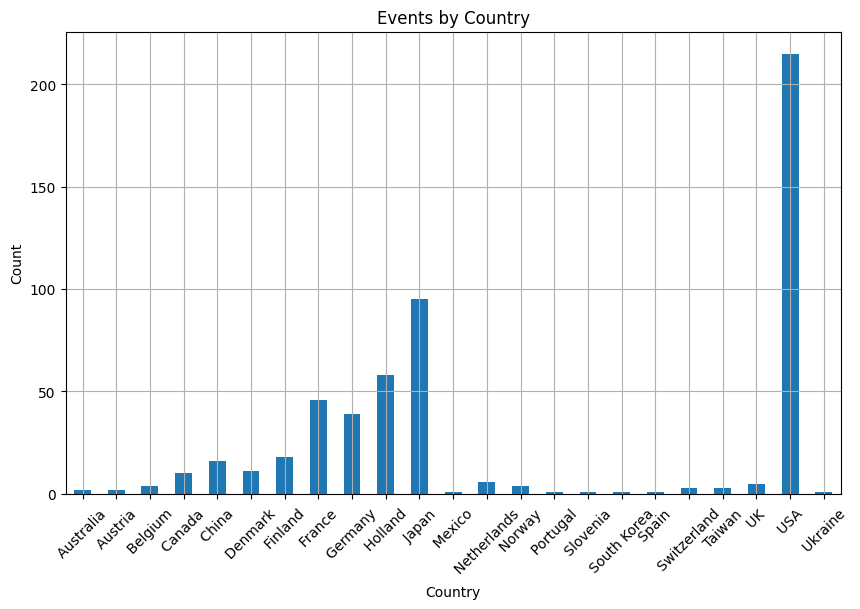

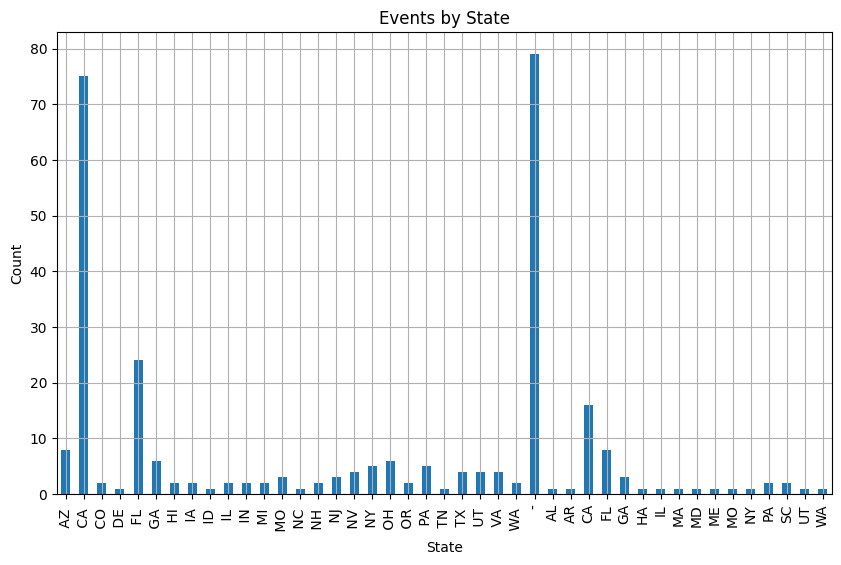

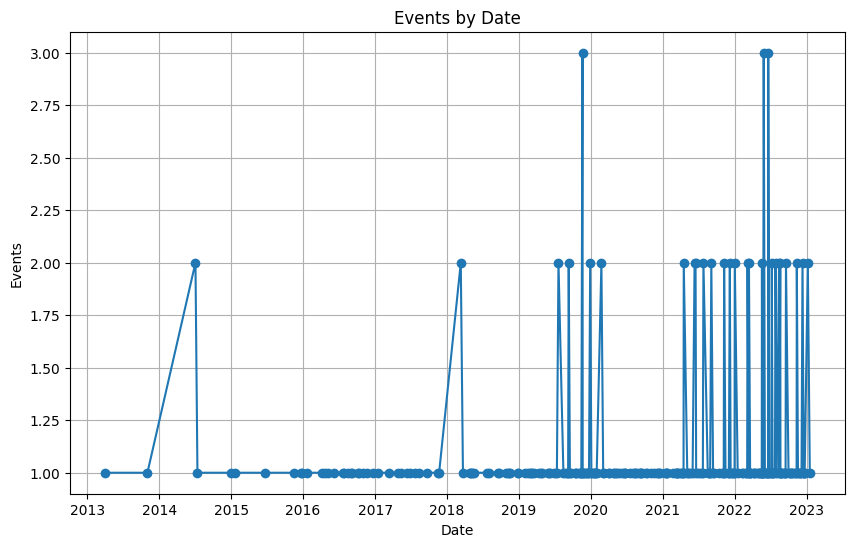

In [ ]:
if not os.path.exists(TESLA_CSV_PATH):
    raise FileNotFoundError('Tesla-Deaths.csv not found.')
df=pd.read_csv(TESLA_CSV_PATH)
print('Shape:', df.shape); print(df.head(3))
df.columns=(df.columns.str.strip().str.replace(r'[^0-9a-zA-Z]+','_',regex=True).str.strip('_').str.lower())
if 'date' in df.columns:
    df['date_parsed']=pd.to_datetime(df['date'], errors='coerce')
if 'year' in df.columns:
    df['year_num']=pd.to_numeric(df['year'], errors='coerce')
na=df.isna().sum().sort_values(ascending=False); print('NA Top:', na.head(10))
unin=[c for c in df.columns if df[c].nunique(dropna=True)<=1]
if unin: df=df.drop(columns=unin)
if df.duplicated().sum(): df=df.drop_duplicates().reset_index(drop=True)
df.to_csv(f'{DATA_ROOT}/Tesla-Deaths.cleaned.csv', index=False)
print('Cleaned saved to:', f'{DATA_ROOT}/Tesla-Deaths.cleaned.csv')
# Quick plots
import matplotlib.pyplot as plt
def bar(series,title,xlabel,rot=0):
    vc=series.value_counts().sort_index(); ax=vc.plot(kind='bar'); ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('Count');
    if rot: plt.xticks(rotation=rot); plt.show()
if 'year_num' in df.columns: bar(df['year_num'].dropna().astype(int),'Events by Year','Year')
if 'country' in df.columns: bar(df['country'].dropna(),'Events by Country','Country',45)
if 'state' in df.columns: bar(df['state'].dropna(),'Events by State','State',90)
if 'date_parsed' in df.columns:
    s=df['date_parsed'].dropna().dt.date.value_counts().sort_index(); s.plot(kind='line', marker='o'); plt.title('Events by Date'); plt.xlabel('Date'); plt.ylabel('Events'); plt.show()

## 7) Conclusions Template

In [ ]:
print('''\nPart 1 — Object Detection\n- YOLOv8n trained on CSV-derived labels.\n- Fill in mAP/PR from run results.\n\nPart 2 — Tesla EDA\n- Cleaned data; plotted key trends.\n- Add your insights here.\n''')


Part 1 — Object Detection
- YOLOv8n trained on CSV-derived labels.
- Fill in mAP/PR from run results.

Part 2 — Tesla EDA
- Cleaned data; plotted key trends.
- Add your insights here.



Saving pexels-joshsorenson-139303.jpg to pexels-joshsorenson-139303 (1).jpg
Running detection on pexels-joshsorenson-139303 (1).jpg...

image 1/1 /content/pexels-joshsorenson-139303 (1).jpg: 448x640 3 cars, 13 pedestrians, 44.3ms
Speed: 3.2ms preprocess, 44.3ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/capstone_data/runs/test_pred/car_test


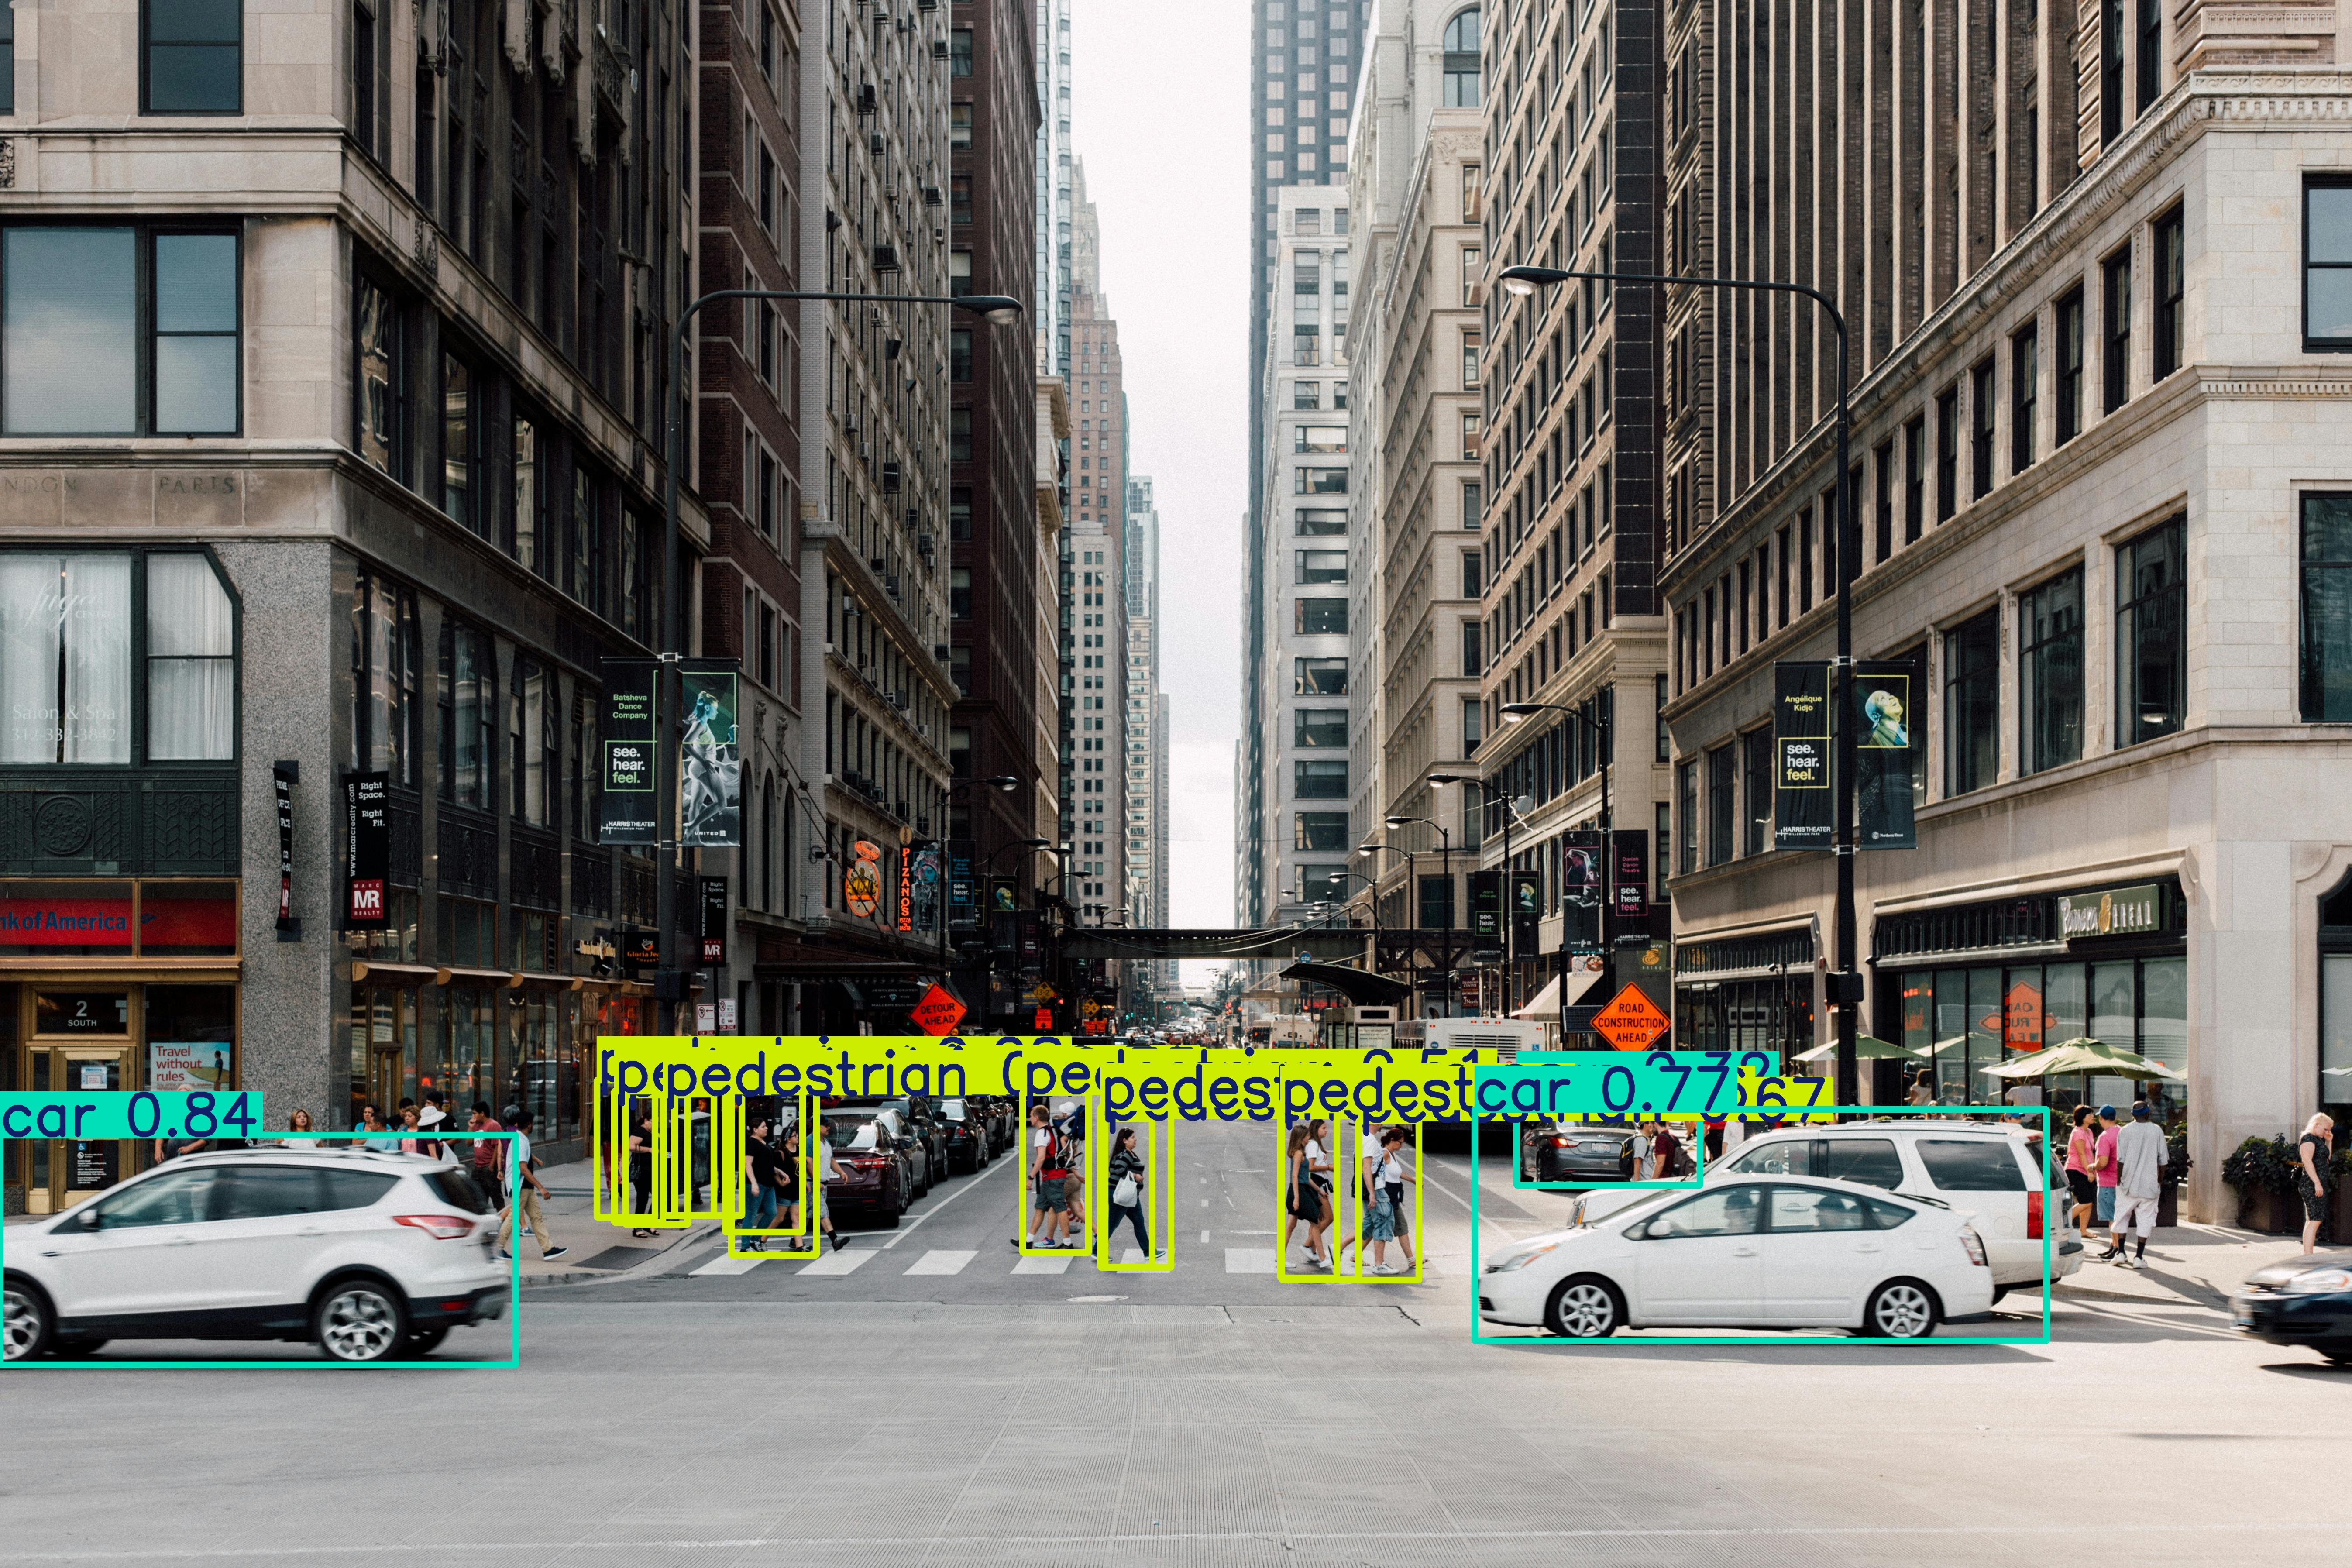

In [ ]:
from google.colab import files
from ultralytics import YOLO
from IPython.display import Image, display
import os

# 1️⃣ Upload a test image (e.g. car.jpg)
uploaded = files.upload()

# 2️⃣ Load your trained model
best_weights = f"{DATA_ROOT}/runs/yolov8_from_csv/weights/best.pt"
assert os.path.exists(best_weights), "❌ No trained weights found. Train YOLO first."

model = YOLO(best_weights)

# 3️⃣ Run inference on the uploaded image
for name in uploaded.keys():
    print(f"Running detection on {name}...")
    results = model.predict(source=name, conf=0.25, save=True, project=f"{DATA_ROOT}/runs/test_pred", name="car_test")

# 4️⃣ Display the output image
out_dir = f"{DATA_ROOT}/runs/test_pred/car_test"
for img_file in os.listdir(out_dir):
    if img_file.lower().endswith((".jpg", ".png")):
        display(Image(filename=os.path.join(out_dir, img_file)))
